# Geodesic Solver

In [1]:
import sys
sys.path.append("/home/alok/projects/py-manifolds")

In [2]:
import time

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from manifolds.geodesic import explicit_step, midpoint_step, make_exp_map_step
from manifolds.manifold import ChartPoint, Cotangent, ContravariantTensor, CovariantTensor, Tangent, Tensor
from manifolds.sphere import Sphere, StereographicChart, SpherePoint
from manifolds.riemannian import levi_civita

In [3]:
%matplotlib widget

In [4]:
sphere = Sphere(5.)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


The goal here is to implement the exponential map with a simple ODE solver.
The exponential map is defined by a second-order linear ODE, which can be converted to a system of first-order ODEs with parameters x and v.

$$\dot x(t) = v(t)$$

$$ \dot v^k(t) = -v^i(t) v^j(t)\Gamma^k_{ij}(x(t)) $$

What does taking a step look like?

- You are at some point $x_0$ with velocity $v_0$
- If you are in explicit mode, then you adjust the coordinates of $x$ by $dt \cdot v$, and you adjust the coordinates of $v$ by evaluating the Christoffel symbol product.
- Explicit mode is equivalent to approximating x' and v' with forward differences in time.
- If you are in implicit mode, then you approximate x' and v' with backward differences, and then you cry because you need to solve a nonlinear system involving a black box.
- So I guess we're sticking to explicit mode.

In [5]:
def make_chart_reset(manifold, chart_cls):
    @jax.jit
    def to_preferred_chart(x_coords, v_coords, chart_array):
        old_chart = chart_cls.of_array(chart_array)
        old_x = ChartPoint(x_coords, old_chart)
        old_v = Tangent(old_x, v_coords)
        pt = old_x.to_point()
        pref_chart = manifold.preferred_chart(pt)
        new_x = ChartPoint.of_point(pt, pref_chart)
        new_v = old_v.to_chart(pref_chart)
        return new_x.coords, new_v.v_coords, pref_chart.to_array()
    
    return to_preferred_chart

In [6]:
exp_map_step = make_exp_map_step(lambda cp: levi_civita(sphere, cp), midpoint_step, StereographicChart)
reset_chart = make_chart_reset(sphere, StereographicChart)

In [7]:
signed_r = jnp.array(-5.)
x_coords = jnp.array([3., 0.])
v_coords = jnp.array([0., 1.])
dt = jnp.array(0.01)


history = []
r_history = []
outer_its = 100
inner_its = 100

_, _ = exp_map_step(x_coords, v_coords, signed_r, dt)  # trigger JIT
_, _, _ = reset_chart(x_coords, v_coords, signed_r)  # likewise

start_time = time.time()
for i in range(outer_its):
    for j in range(inner_its):
        x_coords, v_coords = exp_map_step(x_coords, v_coords, signed_r, dt)
    history.append(x_coords.tolist())
    r_history.append(signed_r.tolist())
    # resetting the chart is nice but it makes the plot uglier
    # x_coords, v_coords, signed_r = reset_chart(x_coords, v_coords, signed_r)
    
end_time = time.time()
print(f"Ran {outer_its * inner_its} iterations in {end_time - start_time} seconds")
# for some reason, even after triggering JIT pre-benchmark, the first run is 2x slower than the second run
print(x_coords, v_coords)
print(x_coords @ x_coords)

Ran 10000 iterations in 0.044458866119384766 seconds
[ 2.4723444 -2.009864 ] [0.39211088 1.0687603 ]
10.1520405


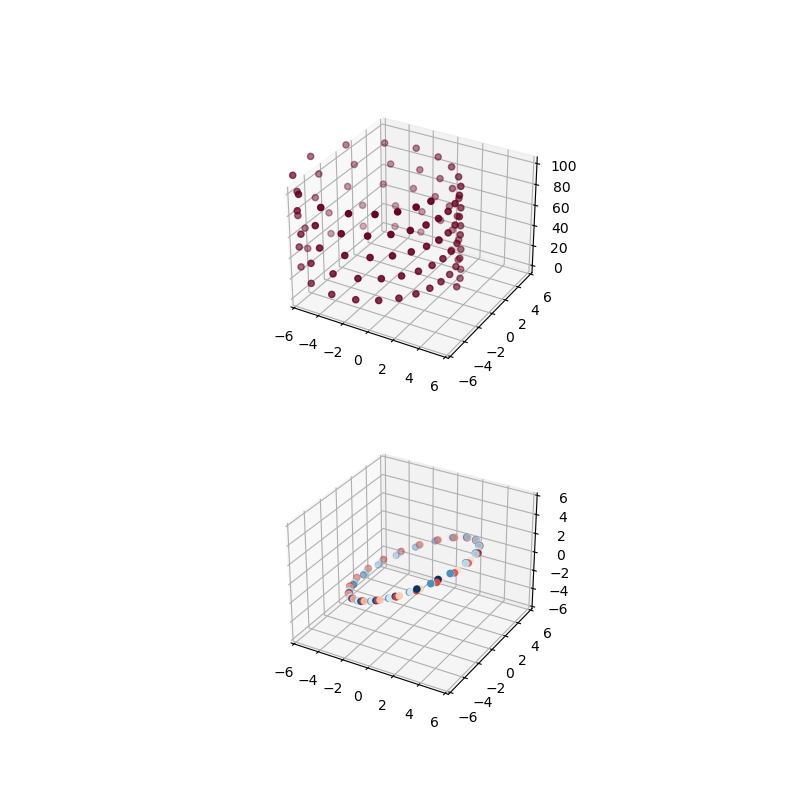

In [8]:
hist_array = np.array(history)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(2, 1, 1, projection="3d")
ax.scatter(hist_array[:, 0], hist_array[:, 1], np.arange(len(history)), c=r_history, cmap="RdBu")
coord_range = [-6, 6]
ax.set_xlim(coord_range)
ax.set_ylim(coord_range)

ax2 = fig.add_subplot(2, 1, 2, projection="3d")
hist_embedded = np.array([StereographicChart(r).coords_to_point(jnp.array(x)).coords for x, r in zip(history, r_history)])
ax2.scatter(hist_embedded[:, 0], hist_embedded[:, 1], hist_embedded[:, 2], c=np.arange(len(history)), cmap="RdBu")
ax2.set_xlim(coord_range)
ax2.set_ylim(coord_range)
ax2.set_zlim(coord_range)

plt.show()